## 0. References

- Normality test:
https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
- Outlier detection:
https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
- Handle imbalanced classes:
https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
- Flask web development framework:
https://flask.palletsprojects.com/en/2.2.x/

## 1. Problem formulation

This dataset contains data on the customers of a Call center. In addition to basic demographic information of customers, such as state, area, and their mobile/telephone/customer service usage,  this dataset also includes rather or not a particular customer churned, which then will be utilized to develop a Churn Prediction Model. 

In [1]:
import os
import time
import copy
import joblib
import pandas as pd
import numpy as np
from numpy.random import seed
from scipy.stats import normaltest
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.utils import resample
# Self-defined functions
from Modules import Module_churn as mm
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
# Initiate the random number generator
seed(1)

## 2. Data preparation

In [2]:
# Using os library to generate relative path to avoid the problem of OS-specific separator.
wd = os.getcwd()
input_data = os.path.join(wd, 'Dataset','customer_data_edited.csv')
# Load the dataset 
df = pd.read_csv(input_data, header = 0)

### Basic information about the dataset

In [3]:
# Get a peek of data
df.head()

,recordID,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,customer_id
0,1,HI,101,510,no,no,0,70.9,123,12.05,...,18.01,236.0,73,10.62,10.6,3,2.86,3,no,23383607.0
1,2,MT,137,510,no,no,0,223.6,86,38.01,...,20.81,94.2,81,4.24,9.5,7,2.57,0,no,22550362.0
2,3,OH,103,408,no,yes,29,294.7,95,50.10,...,20.17,300.3,127,13.51,13.7,6,3.70,1,no,59063354.0
3,4,NM,99,415,no,no,0,216.8,123,36.86,...,10.74,220.6,82,9.93,15.7,2,4.24,1,no,25464504.0
4,5,SC,108,415,no,no,0,197.4,78,33.56,...,10.54,204.5,107,9.20,7.7,4,2.08,2,no,691824.0


In [4]:
# Shape of the dataset
df.shape

(12892, 22)

In [5]:
# Column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12892 entries, 0 to 12891
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   recordID                       12892 non-null  int64  
 1   state                          12892 non-null  object 
 2   account_length                 12892 non-null  int64  
 3   area_code                      12892 non-null  int64  
 4   international_plan             12892 non-null  object 
 5   voice_mail_plan                12892 non-null  object 
 6   number_vmail_messages          12892 non-null  int64  
 7   total_day_minutes              12892 non-null  float64
 8   total_day_calls                12892 non-null  int64  
 9   total_day_charge               12892 non-null  float64
 10  total_eve_minutes              12892 non-null  float64
 11  total_eve_calls                12892 non-null  int64  
 12  total_eve_charge               12892 non-null 

In [6]:
# Summary of datatypes
df.dtypes

recordID                           int64
state                             object
account_length                     int64
area_code                          int64
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
customer_id                      float64
dtype: object

The <b>area_code</b> columns has the datatype of int64. However, this is actually a nominal feature, so we need to cast its type into int64.

In [7]:
df["area_code"] = df["area_code"].astype(object)

### Copy the original dataframe into a backup dataframe

In [8]:
backup_df = df.copy(deep=True)
backup_df.head()

,recordID,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,customer_id
0,1,HI,101,510,no,no,0,70.9,123,12.05,...,18.01,236.0,73,10.62,10.6,3,2.86,3,no,23383607.0
1,2,MT,137,510,no,no,0,223.6,86,38.01,...,20.81,94.2,81,4.24,9.5,7,2.57,0,no,22550362.0
2,3,OH,103,408,no,yes,29,294.7,95,50.10,...,20.17,300.3,127,13.51,13.7,6,3.70,1,no,59063354.0
3,4,NM,99,415,no,no,0,216.8,123,36.86,...,10.74,220.6,82,9.93,15.7,2,4.24,1,no,25464504.0
4,5,SC,108,415,no,no,0,197.4,78,33.56,...,10.54,204.5,107,9.20,7.7,4,2.08,2,no,691824.0


### Check null values in the dataset

In [9]:
print("The dataset has {} null values".format(df.isna().sum().sum()))

The dataset has 0 null values


### Drop unnecessary columns

In [10]:
# Drop the recordID and customer_id columns
df.drop("recordID", axis = 1, inplace = True) 
df.drop("customer_id", axis = 1, inplace = True) 

In [11]:
# Re-check the dataframe
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,HI,101,510,no,no,0,70.9,123,12.05,211.9,73,18.01,236.0,73,10.62,10.6,3,2.86,3,no
1,MT,137,510,no,no,0,223.6,86,38.01,244.8,139,20.81,94.2,81,4.24,9.5,7,2.57,0,no
2,OH,103,408,no,yes,29,294.7,95,50.10,237.3,105,20.17,300.3,127,13.51,13.7,6,3.70,1,no
3,NM,99,415,no,no,0,216.8,123,36.86,126.4,88,10.74,220.6,82,9.93,15.7,2,4.24,1,no
4,SC,108,415,no,no,0,197.4,78,33.56,124.0,101,10.54,204.5,107,9.20,7.7,4,2.08,2,no


## 3. Exploratory Data Analysis

### a. The summary statistics of the dataset

In [12]:
df.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000
mean,100.676621,7.996665,180.162023,100.266599,30.628086,200.711852,100.137139,17.060717,200.557834,100.038241,9.025192,10.244702,4.467654,2.766584,1.563683
std,39.806413,13.641977,54.207056,19.946657,9.215171,50.781851,19.894032,4.316445,50.632872,19.749714,2.278507,2.782623,2.466493,0.751269,1.310606
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,144.000000,87.000000,24.480000,166.200000,87.000000,14.130000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,180.000000,101.000000,30.600000,201.150000,100.000000,17.095000,200.800000,100.000000,9.040000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,19.000000,216.300000,114.000000,36.770000,234.900000,114.000000,19.970000,235.100000,113.000000,10.580000,12.100000,6.000000,3.270000,2.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


### b. Heatmap of the correlations between features

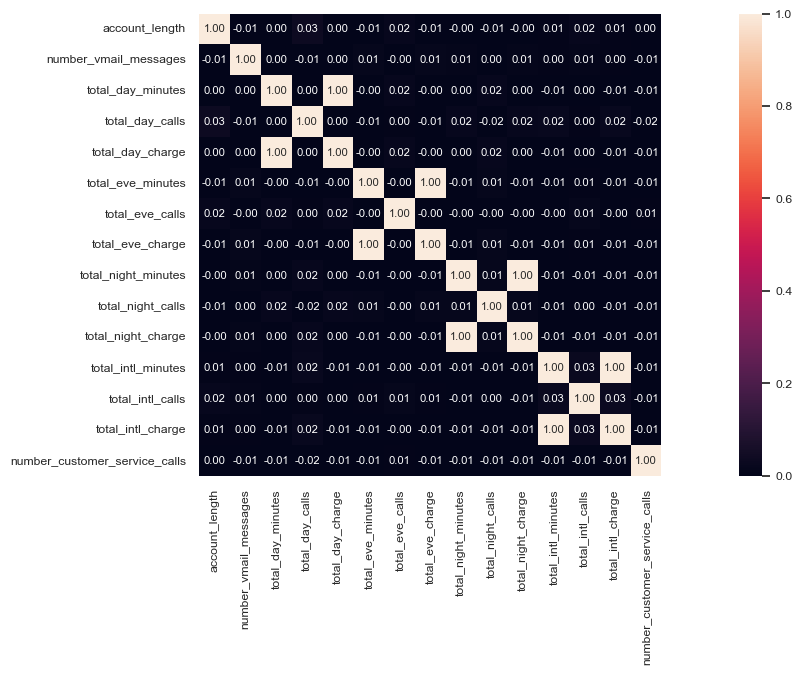

In [13]:
# Correlation heatmap
fig = plt.figure(figsize=(20,6))
corr = np.corrcoef(df.select_dtypes(exclude = 'object').values.T)
sns.set(font_scale=0.8)
hm = sns.heatmap(corr, cbar=True, annot=True, square=True,
                fmt='.2f', annot_kws={'size': 8}, vmin=0, vmax=1,
                yticklabels=df.select_dtypes(exclude = 'object').columns, 
                xticklabels=df.select_dtypes(exclude = 'object').columns)
plt.show()

Clearly, there is a perfect correlation, or a direct relationship, between:<br>
- <b>total_day_charge</b> and <b>total_day_minutes</b><br>
- <b>total_eve_charge</b> and <b>total_eve_minutes</b><br>
- <b>total_night_charge</b> and <b>total_nigh_minutes</b><br>
- <b>total_intl_charge</b> and <b>total_intl_minutes</b><br>
Therefore, we can drop 4 columns: total_day_charge, total_eve_charge, total_night_charge and total_intl_charge.

In [14]:
df.drop("total_day_charge", axis = 1, inplace = True) 
df.drop("total_eve_charge", axis = 1, inplace = True) 
df.drop("total_night_charge", axis = 1, inplace = True) 
df.drop("total_intl_charge", axis = 1, inplace = True) 

In [15]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn
0,HI,101,510,no,no,0,70.9,123,211.9,73,236.0,73,10.6,3,3,no
1,MT,137,510,no,no,0,223.6,86,244.8,139,94.2,81,9.5,7,0,no
2,OH,103,408,no,yes,29,294.7,95,237.3,105,300.3,127,13.7,6,1,no
3,NM,99,415,no,no,0,216.8,123,126.4,88,220.6,82,15.7,2,1,no
4,SC,108,415,no,no,0,197.4,78,124.0,101,204.5,107,7.7,4,2,no


### c. Save cleaned dataset

In [16]:
output_data = os.path.join(wd, 'Dataset','TermProject_prepared.csv')
df.to_csv(output_data, index=False)

### d. Detecting Multicollinearity using Variance Inflation Factors (VIF)

#### Calculate the Variance Influence Factor (VIF) 

In [17]:
df_vif = mm.calculateVIF(df.select_dtypes(exclude = 'object'))
pd.set_option('float_format', '{:5f}'.format)
df_vif.sort_values(by='vif', ascending=False)

,feature,vif
7,total_night_calls,21.965064
5,total_eve_calls,21.876883
3,total_day_calls,21.843613
6,total_night_minutes,14.884431
4,total_eve_minutes,14.707934
8,total_intl_minutes,13.192680
2,total_day_minutes,11.204161
0,account_length,7.135635
9,total_intl_calls,4.210469
10,number_customer_service_calls,2.390193


#### Re-scale the dataset with StandardScaler()

In [18]:
scaled_df = mm.makeScale(df.select_dtypes(exclude = 'object'))
scaled_df

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls
0,0.008124,-0.586203,-2.015720,1.139754,0.220326,-1.364137,0.700010,-1.369098,0.127689,-0.595060,1.095961
1,0.912536,-0.586203,0.801365,-0.715265,0.868221,1.953569,-2.100650,-0.964013,-0.267636,1.026739,-1.193145
2,0.058369,1.539670,2.113054,-0.264044,0.720524,0.244448,1.969986,1.365225,1.241790,0.621289,-0.430110
3,-0.042121,-0.586203,0.675916,1.139754,-1.463411,-0.610113,0.395848,-0.913377,1.960564,-1.000510,-0.430110
4,0.183982,-0.586203,0.318015,-1.116351,-1.510674,0.043375,0.077861,0.352513,-0.914533,-0.189610,0.332925
...,...,...,...,...,...,...,...,...,...,...,...
12887,-1.901190,-0.586203,-0.846085,-0.113637,0.031275,0.445521,-0.091996,-0.001936,0.846464,0.215839,0.332925
12888,0.309595,-0.586203,0.659312,-0.364316,0.775664,-0.760918,-0.866227,1.162683,-1.920817,0.215839,1.095961
12889,-0.318469,1.686282,0.026529,-0.464587,0.245927,0.998472,0.143038,0.200606,0.415199,-0.189610,-0.430110
12890,0.485453,-0.586203,-0.032507,-0.163773,-0.638281,0.646594,-1.581205,-0.356386,-0.339514,1.837638,-0.430110


#### Re-calculate the Variance Influence Factor (VIF) 

In [19]:
scaled_df_vif = mm.calculateVIF(scaled_df)
scaled_df_vif.sort_values(by='vif', ascending=False)

,feature,vif
3,total_day_calls,1.002615
0,account_length,1.002056
9,total_intl_calls,1.001709
8,total_intl_minutes,1.001704
6,total_night_minutes,1.001197
4,total_eve_minutes,1.001183
7,total_night_calls,1.001104
10,number_customer_service_calls,1.001037
2,total_day_minutes,1.000838
5,total_eve_calls,1.000833


Obviously, all features have small VIF values. We can confidently say that there is no multicollinearity among features in this dataset.

### e. Feature observation and Hypothesis

#### Customers state (state)

Text(0.5, 1.0, 'Number of customers by state')

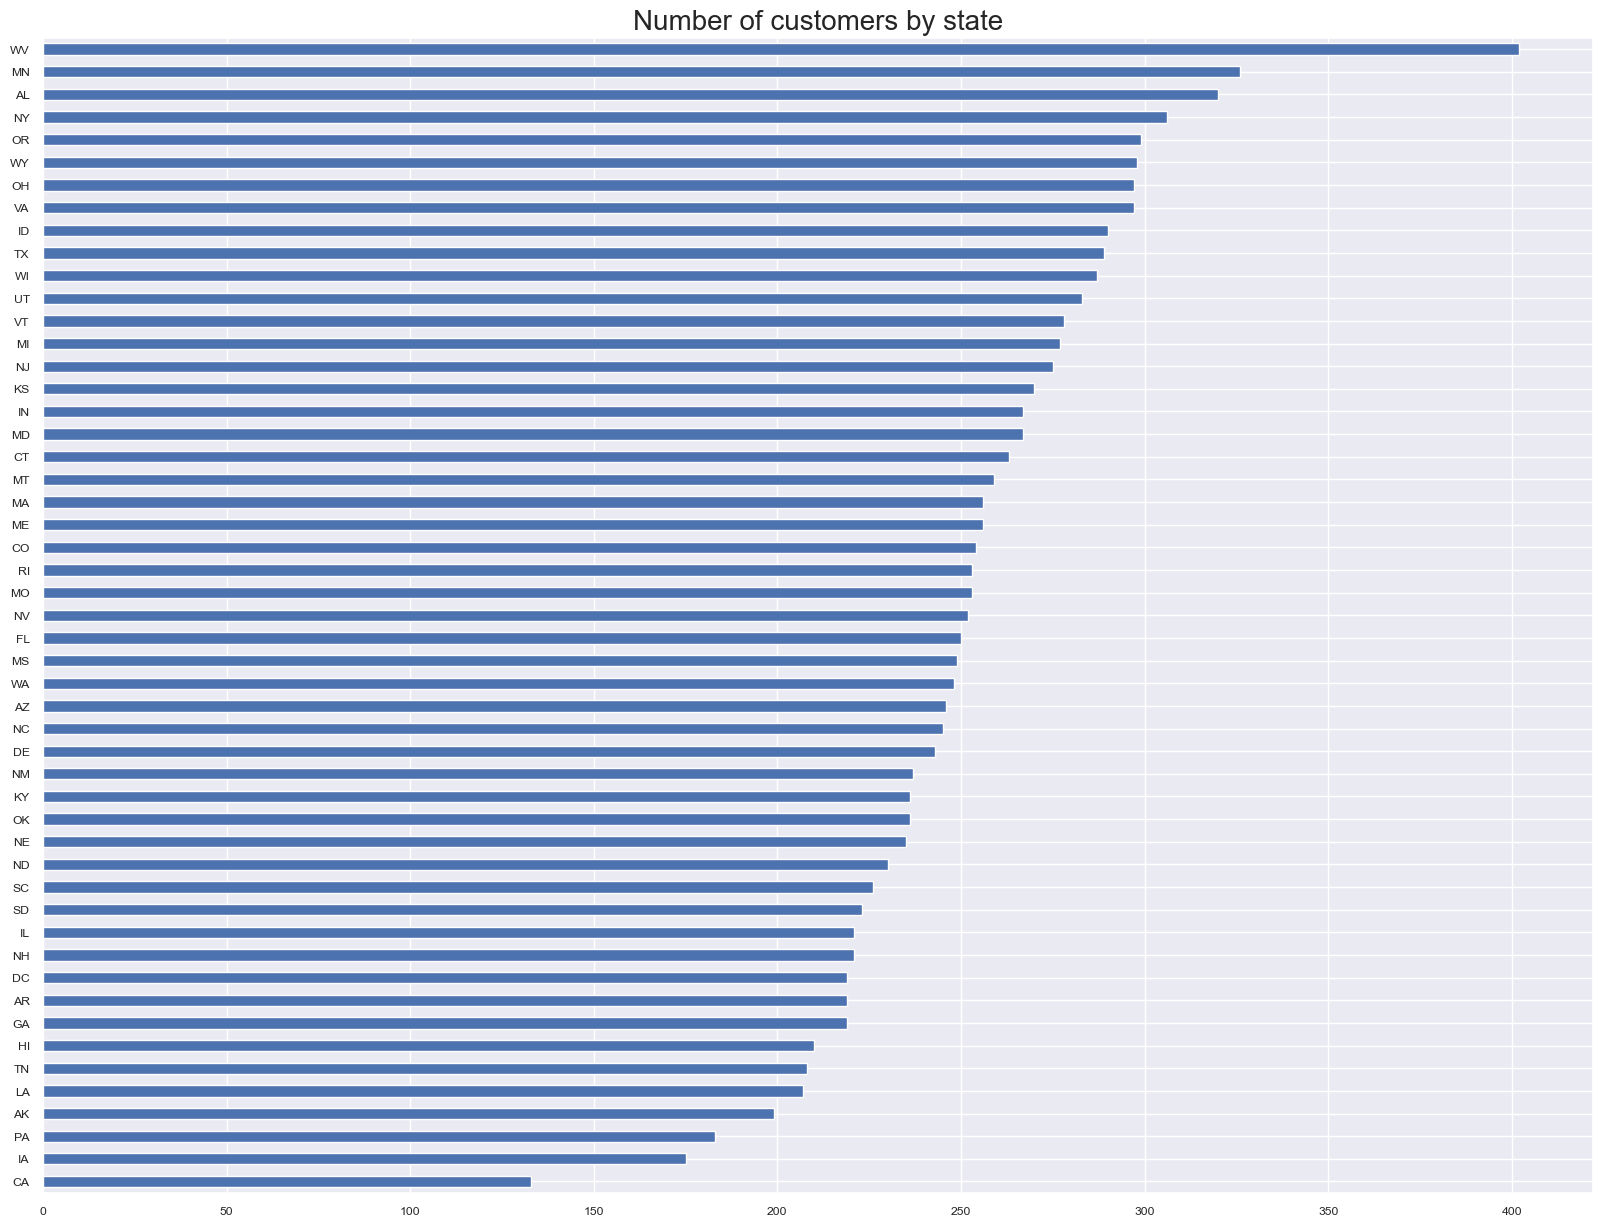

In [20]:
# Plot the distribution
fig = plt.figure(figsize=(20,15))
df["state"].value_counts().sort_values(ascending=False).plot(kind="barh").invert_yaxis()
plt.title('Number of customers by state', fontsize=20)

There is no significant difference in the number of customers living in states of the US.

#### Age of account in months (account_length)

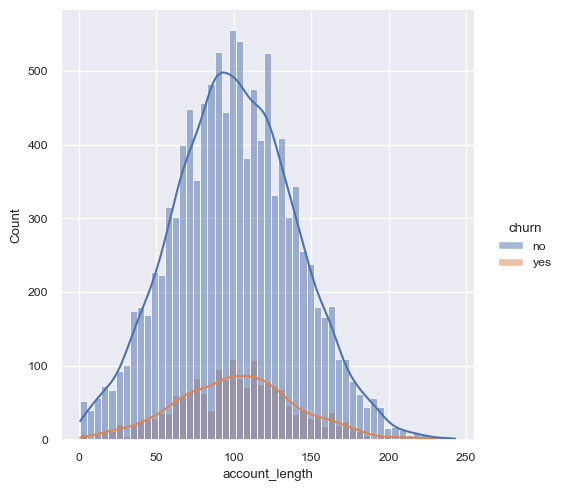

In [21]:
# Plot the distribution
sns.displot(data=df, x="account_length", kde=True, hue = "churn")

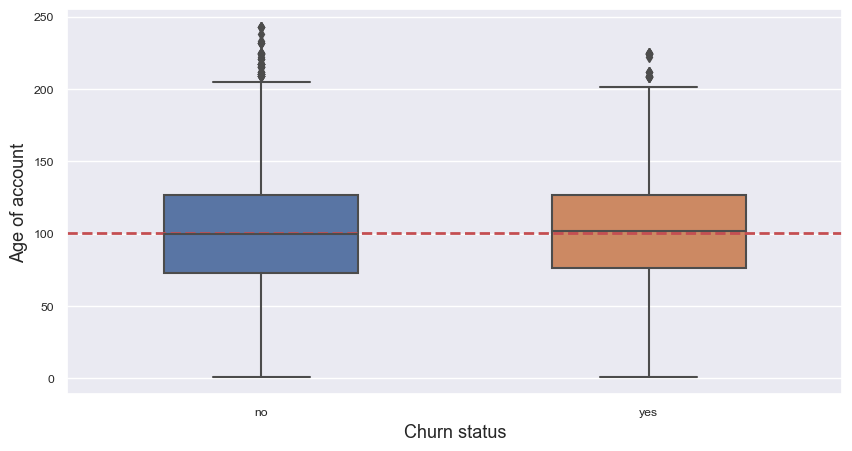

In [22]:
plt.figure(figsize=(10,5))
sns.boxplot(x="churn", y="account_length", data=df, width=0.5)
plt.xlabel("Churn status", fontsize=13)
plt.ylabel("Age of account", fontsize=13)
plt.axhline(df["account_length"].mean(),color='r',linestyle='dashed',linewidth=2)

Though there are certain outliers, it is clear that almost all values of <b>account_length</b> lie in a symmetrical fashion mostly situated around the Mean. <br>The Median is in the middle of the box, and the whiskers are about the same on both sides of the box, so the distribution of <b>account_length</b> is likely to follow a normal distribution.
<br> Since the number of observations is more than 5000, <b>Shapiro-Wilk Test</b> is not applicable here, so we will test the normality of <b>account_length</b> by the <b>D'Agostino-Pearson Test</b> below: <br> 
- Null hypothesis (H0): The feature follows a normal distribution
- Significance level (alpha) = 0.05

In [23]:
mm.testNorm(df["account_length"])

Statistics=31.588, p=0.000
The feature does not follows a normal distribution (reject H0)


#### Area code (area_code)

Text(0.5, 1.0, 'Number of customers by area')

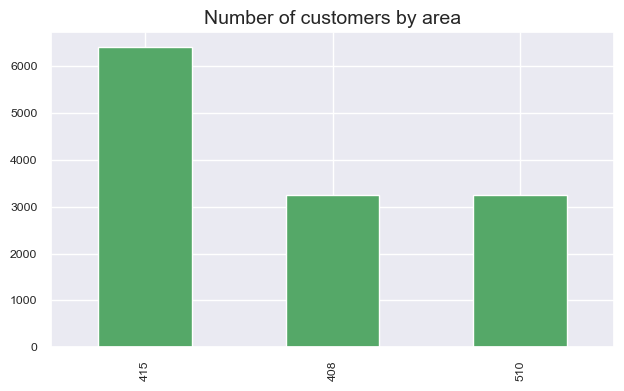

In [24]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(2,2,1)
df["area_code"].value_counts().sort_values(ascending=False).plot(kind="bar", color = "g")
plt.title('Number of customers by area', fontsize=14)

Half of the customers reside in the area code 415, and the number of those who live in 408 and 510 areas are roughly equal. 

#### International calling plan (international_plan)

Text(0, 0.5, '')

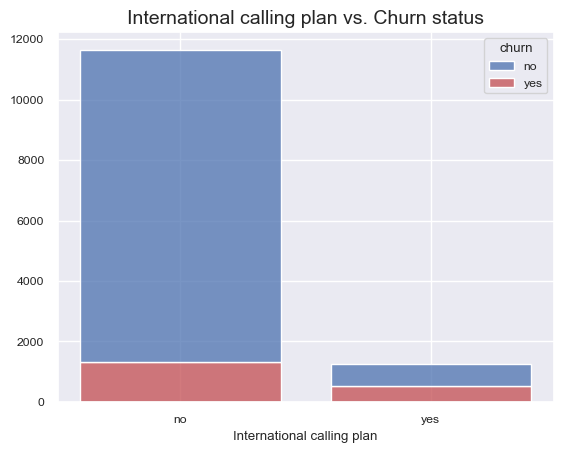

In [25]:
ax = sns.histplot(
    df,
    x='international_plan',
    hue='churn',
    multiple='stack',
    palette=['b','r'],
    shrink=0.8
)

ax.set_title('International calling plan vs. Churn status', fontsize=14)
ax.set_xlabel("International calling plan")
ax.set_ylabel(None)

Interestingly, customers who do not have an international calling plan tend to remain more loyal than those who once used this service.  

#### Voice mail plan (voice_mail_plan)

Text(0.5, 0, 'Voidce mail plan')

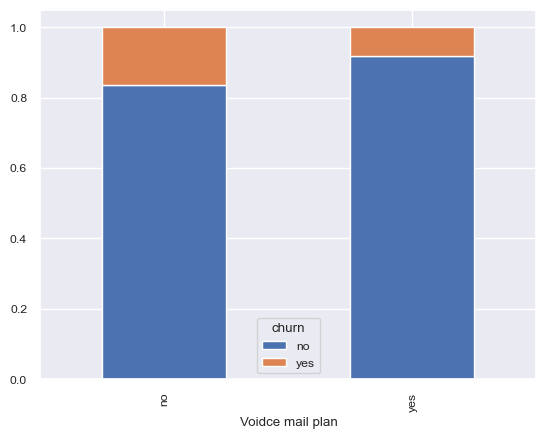

In [26]:
ax = df.groupby('voice_mail_plan')['churn'].value_counts(normalize=True).unstack('churn').plot(kind="bar", stacked=True)
ax.set_xlabel("Voidce mail plan")

The retention rate of customers who have voice mail plan is slightly higher than those who do not. 

#### Number of voicemail messages a customer currently has on the server (number_vmail_messages)

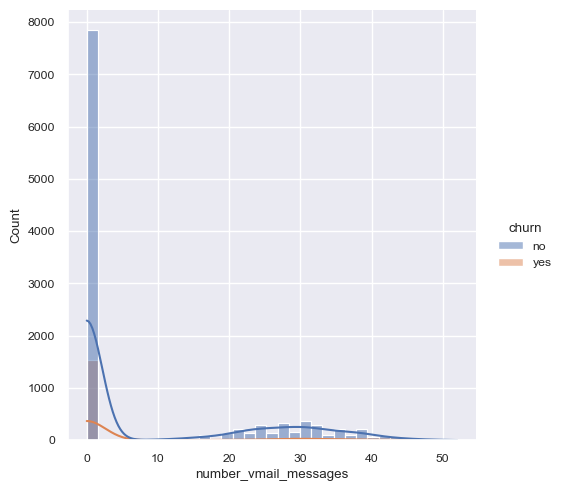

In [27]:
# Plot the distribution
sns.displot(data=df, x="number_vmail_messages", kde=True, hue = "churn")

The distribution of <b>number_vmail_messages</b> does not have a bell-shaped curve, and obviously, most of the customers do not have voicemail messages. 

#### Customers total usage of day minutes in plan (total_day_minutes)

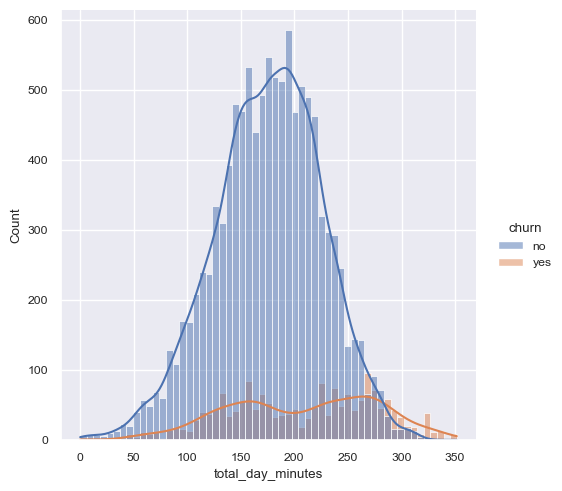

In [28]:
# Plot the distribution
sns.displot(data=df, x="total_day_minutes", kde=True, hue = "churn")

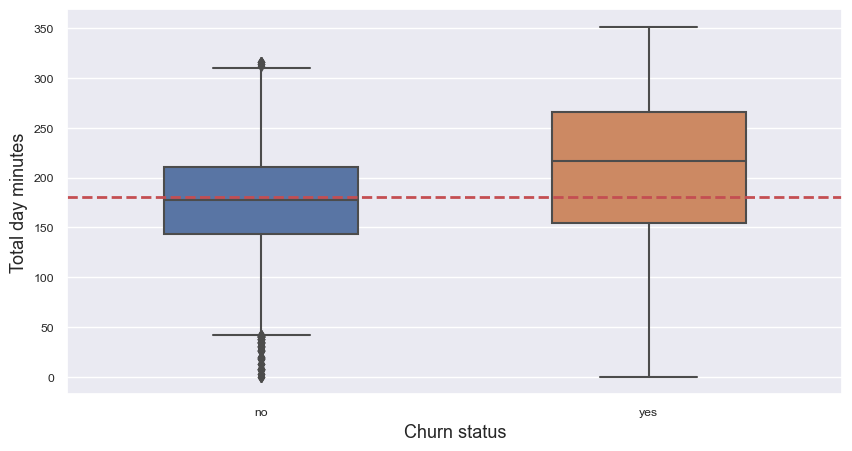

In [29]:
plt.figure(figsize=(10,5))
sns.boxplot(x="churn", y="total_day_minutes", data=df, width=0.5)
plt.xlabel("Churn status", fontsize=13)
plt.ylabel("Total day minutes", fontsize=13)
plt.axhline(df["total_day_minutes"].mean(),color='r',linestyle='dashed',linewidth=2)

In [30]:
mm.testNorm(df["total_day_minutes"])

Statistics=1.074, p=0.585
The feature follows a normal distribution (fail to reject H0)


From the visuals above, feature <b>total_day_minutes</b> is likely to follow a normal distribution. <br>
We will test the normality of this feature by the <b>D'Agostino-Pearson Test</b> as above: <br> 
- Null hypothesis (H0): The feature follows a normal distribution
- Significance level (alpha) = 0.05

Also, the average total usage of day minutes of churned customers appears to be higher than that of retained customers. 

#### Total number of calls customer has made during the day (total_day_calls)

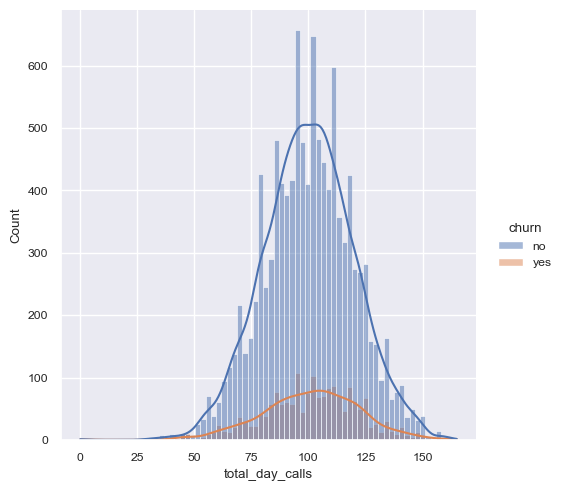

In [31]:
# Plot the distribution
sns.displot(data=df, x="total_day_calls", kde=True, hue = "churn")

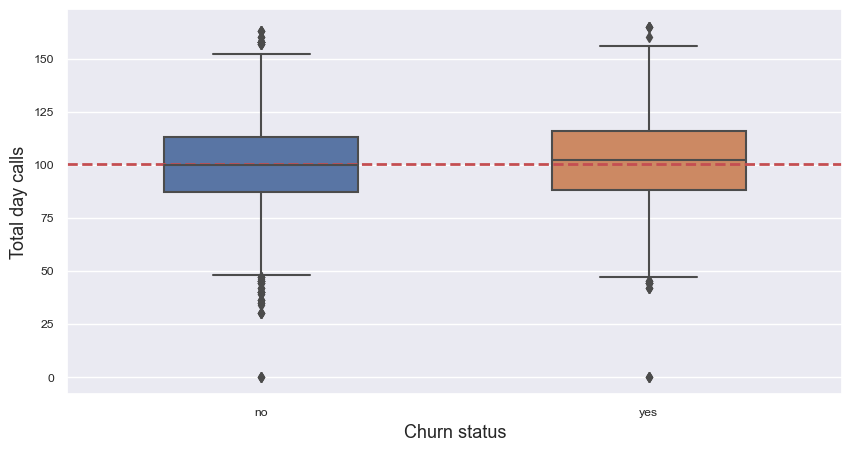

In [32]:
plt.figure(figsize=(10,5))
sns.boxplot(x="churn", y="total_day_calls", data=df, width=0.5)
plt.xlabel("Churn status", fontsize=13)
plt.ylabel("Total day calls", fontsize=13)
plt.axhline(df["total_day_calls"].mean(),color='r',linestyle='dashed',linewidth=2)

In [33]:
mm.testNorm(df["total_day_calls"])

Statistics=36.202, p=0.000
The feature does not follows a normal distribution (reject H0)


Feature <b>total_day_calls</b> looks quite bell-shaped. However, it is just <b>nearly</b> normally-distributed, not exactly drawn from a Gaussian distribution, as tested by the <b>D'Agostino-Pearson Test</b> below: <br> 
- Null hypothesis (H0): The feature follows a normal distribution
- Significance level (alpha) = 0.05

<br> It is notable that though the average total usage of day minutes of churned customers is higher than that of retained customers (as shown above), the number of day calls of the two groups are about the same, meaning that the day call duration of churned customers is longer than retained customers. 

#### Customers total usage of evening minutes in plan (total_eve_minutes)

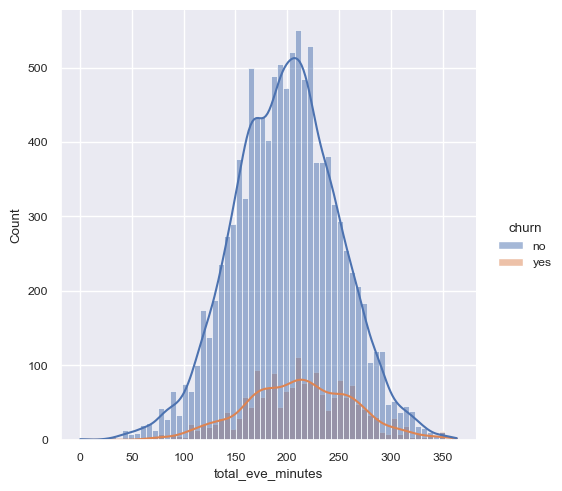

In [34]:
# Plot the distribution
sns.displot(data=df, x="total_eve_minutes", kde=True, hue = "churn")

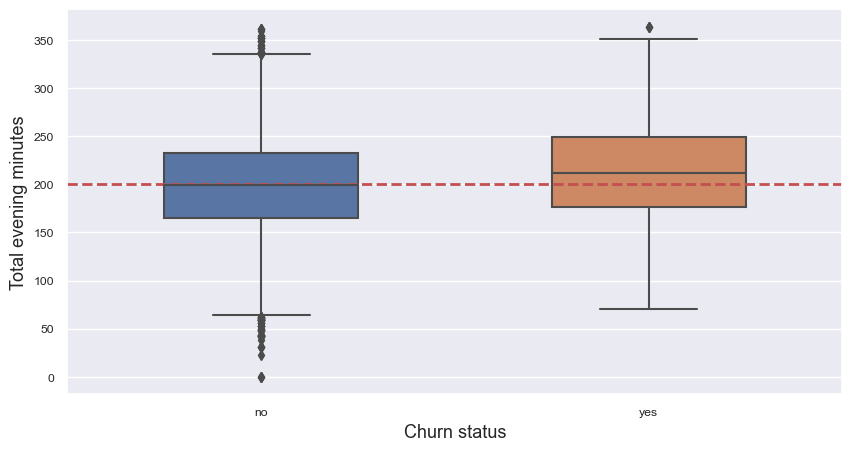

In [35]:
plt.figure(figsize=(10,5))
sns.boxplot(x="churn", y="total_eve_minutes", data=df, width=0.5)
plt.xlabel("Churn status", fontsize=13)
plt.ylabel("Total evening minutes", fontsize=13)
plt.axhline(df["total_eve_minutes"].mean(),color='r',linestyle='dashed',linewidth=2)

In [36]:
mm.testNorm(df["total_eve_minutes"])

Statistics=2.517, p=0.284
The feature follows a normal distribution (fail to reject H0)


This feature seems to have a normal distribution, and there is no clear difference between the call duration of churned and retained customers. 

#### Total number of calls customer has made during the evening (total_eve_calls)

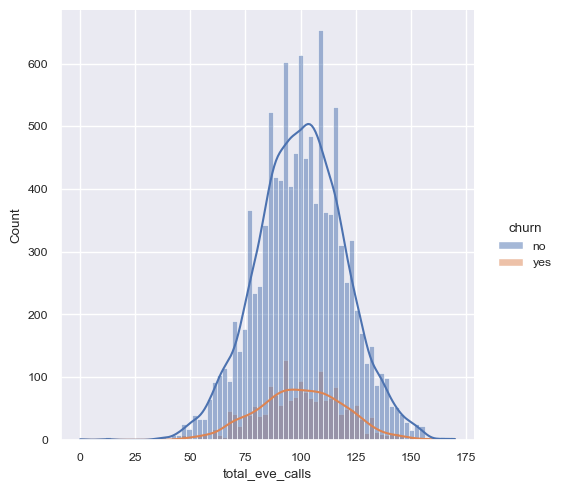

In [37]:
# Plot the distribution
sns.displot(data=df, x="total_eve_calls", kde=True, hue = "churn")

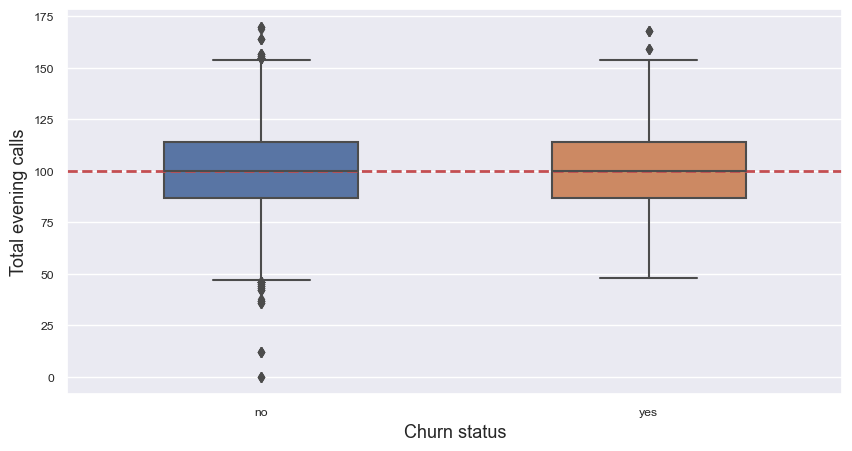

In [38]:
plt.figure(figsize=(10,5))
sns.boxplot(x="churn", y="total_eve_calls", data=df, width=0.5)
plt.xlabel("Churn status", fontsize=13)
plt.ylabel("Total evening calls", fontsize=13)
plt.axhline(df["total_eve_calls"].mean(),color='r',linestyle='dashed',linewidth=2)

The <b>total_eve_calls</b> follows a bell-shaped distribution but does not pass the normality test. 

In [39]:
mm.testNorm(df["total_eve_calls"])

Statistics=18.132, p=0.000
The feature does not follows a normal distribution (reject H0)


#### Customers total usage of night minutes in plan (total_night_minutes)

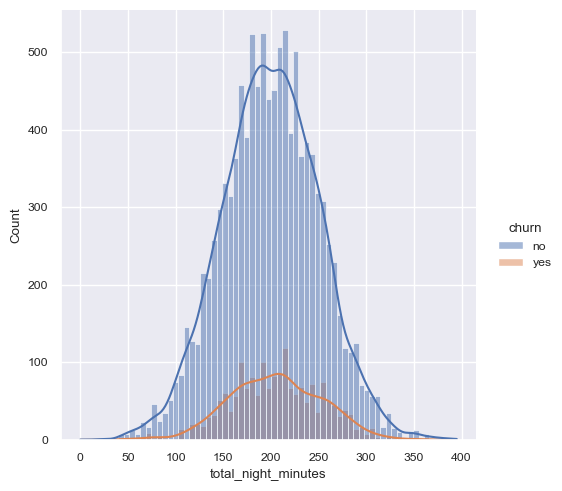

In [40]:
# Plot the distribution
sns.displot(data=df, x="total_night_minutes", kde=True, hue = "churn")

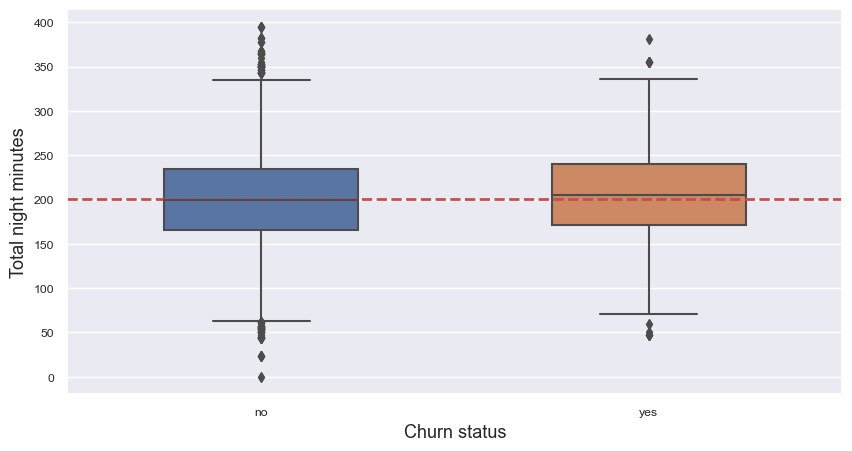

In [41]:
plt.figure(figsize=(10,5))
sns.boxplot(x="churn", y="total_night_minutes", data=df, width=0.5)
plt.xlabel("Churn status", fontsize=13)
plt.ylabel("Total night minutes", fontsize=13)
plt.axhline(df["total_night_minutes"].mean(),color='r',linestyle='dashed',linewidth=2)

It can be seen that all data values are symmetrically distributed around the mean with no skew, meaning that the <b>total_night_minutes</b> feature has a normal distribution. This is also proven by the test below. 

In [42]:
mm.testNorm(df["total_night_minutes"])

Statistics=2.782, p=0.249
The feature follows a normal distribution (fail to reject H0)


#### Total number of calls customer has made during the night (total_night_calls)

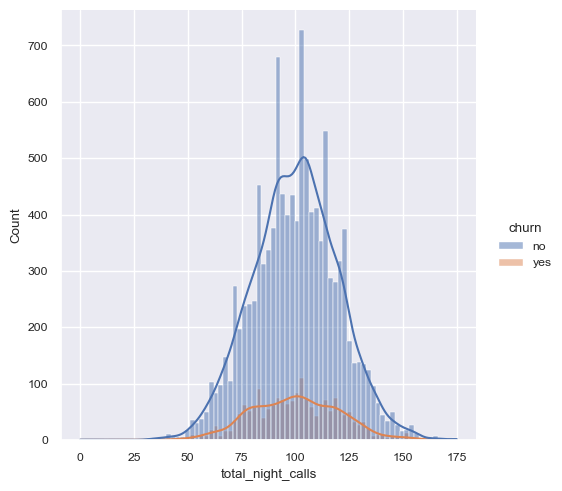

In [43]:
# Plot the distribution
sns.displot(data=df, x="total_night_calls", kde=True, hue = "churn")

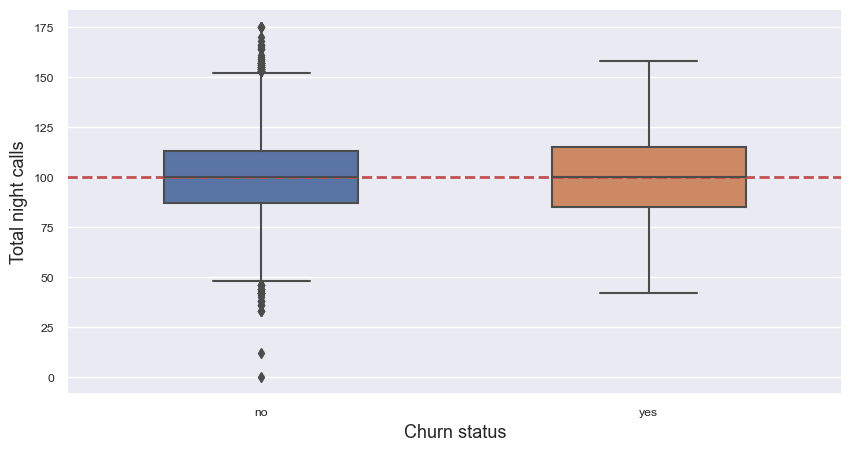

In [44]:
plt.figure(figsize=(10,5))
sns.boxplot(x="churn", y="total_night_calls", data=df, width=0.5)
plt.xlabel("Churn status", fontsize=13)
plt.ylabel("Total night calls", fontsize=13)
plt.axhline(df["total_night_calls"].mean(),color='r',linestyle='dashed',linewidth=2)

Clearly, most of the observations cluster around the mean of the <b>total_night_calls</b> feature. It also satisfies the condition of normality test as below. 

In [45]:
mm.testNorm(df["total_night_calls"])

Statistics=0.615, p=0.735
The feature follows a normal distribution (fail to reject H0)


#### Total international minutes (total_intl_minutes)

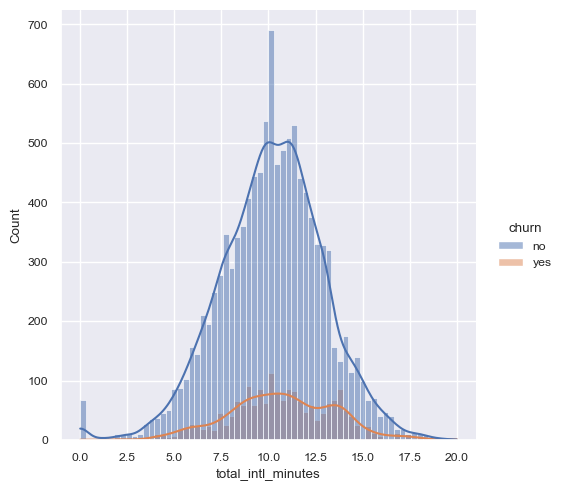

In [46]:
# Plot the distribution
sns.displot(data=df, x="total_intl_minutes", kde=True, hue = "churn")

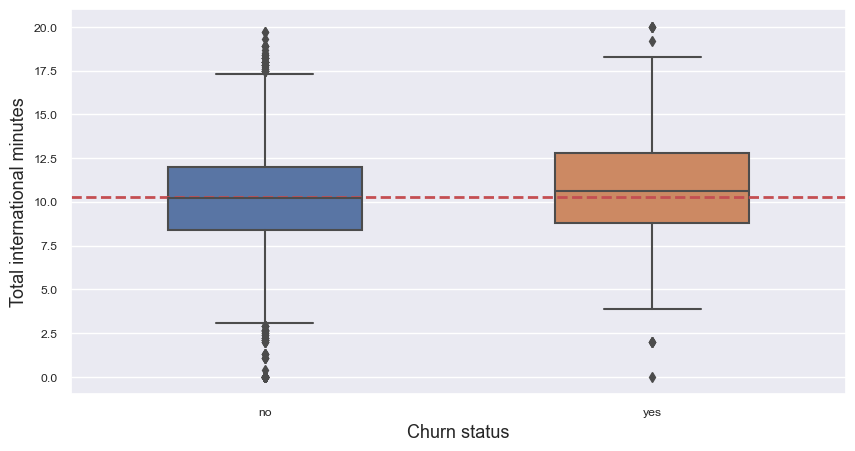

In [47]:
plt.figure(figsize=(10,5))
sns.boxplot(x="churn", y="total_intl_minutes", data=df, width=0.5)
plt.xlabel("Churn status", fontsize=13)
plt.ylabel("Total international minutes", fontsize=13)
plt.axhline(df["total_intl_minutes"].mean(),color='r',linestyle='dashed',linewidth=2)

Not all customers make international phone calls, and while the total international calling minutes of retained customers are quite normally distributed, these figures of churned customers do not. This is the reason why the <b>total_intl_minutes</b>, as a whole, does not satisfy the requirements of Gaussian distribution. 

In [48]:
mm.testNorm(df["total_intl_minutes"])

Statistics=238.600, p=0.000
The feature does not follows a normal distribution (reject H0)


#### Total international calls (total_intl_calls)

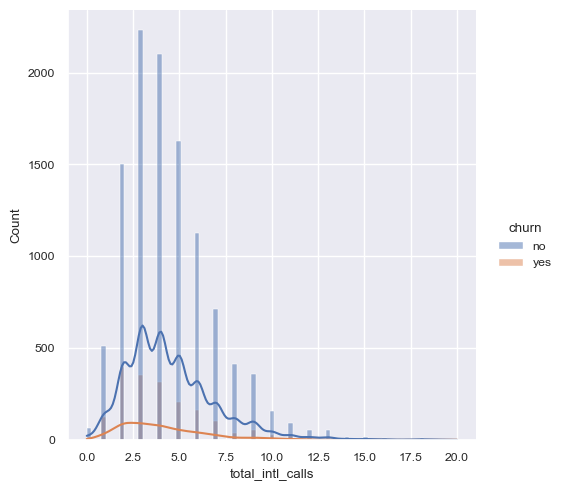

In [49]:
# Plot the distribution
sns.displot(data=df, x="total_intl_calls", kde=True, hue = "churn")

In [50]:
mm.testNorm(df["total_intl_calls"])

Statistics=3303.970, p=0.000
The feature does not follows a normal distribution (reject H0)


It is obvious that customers make much fewer international calls than typical calls regardless of time, and this feature also has a sparse distribution. 

#### How many times the customer has called the IVR system (number_customer_service_calls)

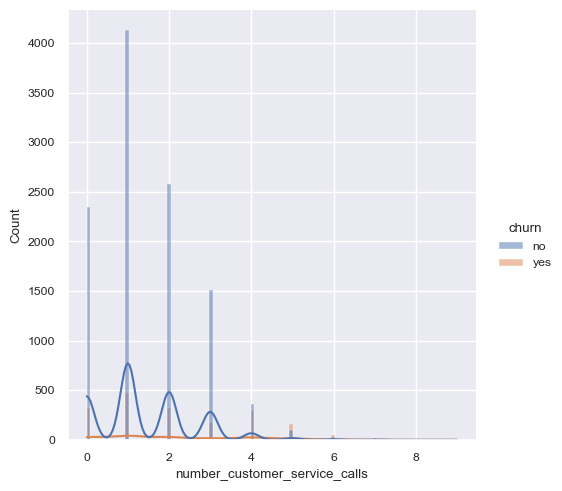

In [51]:
# Plot the distribution
sns.displot(data=df, x="number_customer_service_calls", kde=True, hue = "churn")

Clearly, most customers rarely call the customer service, and none of them make more than 9 calls in total.

### Hypothesis

From the above analyses, there are several hypotheses that can be made:

1. Customers having international calling plan are more unlikely to churn, and therefore feature <b>international_plan</b> would be of great importance. 
2. Customers making more and longer day calls tend to stop using company's phone services more easily. Hence, <b>total_day_minutes</b> could be a prominent indicator of churn customers. 

## 4. Data wrangling and transformation

### a. Convert classes into numeric values

In [52]:
df["churn"] = df["churn"].map({"yes": 1, "no": 0})

### b. Detecting and Treating Outliers

We will carry out the <b>Standard Deviation method</b> to detect outliers on features which have a bell-shaped distribution. 

In [53]:
norm_features = ["account_length",
                "total_day_minutes",
                "total_day_calls",
                "total_eve_minutes",
                "total_eve_calls",
                "total_night_minutes",
                "total_night_calls",
                "total_intl_minutes"]

In [54]:
idx_outliers = []
for feature in norm_features:
    f_outliers = mm.detectOuliers(df[feature])
    idx_outliers.extend(f_outliers)

In [55]:
len(idx_outliers)

324

There are 324 (out of 12892 records) that seem to be outliers. We may consider removing them in the model development phase to improve model accuracy. 

#### Create dataset without outliers

In [56]:
df_normal = df.drop(idx_outliers)

### c. Handle imbalanced classes

In [57]:
df["churn"].value_counts()

0    11069
1     1823
Name: churn, dtype: int64

In order to solve the imbalanced classes problem, we will use the Up-sampling method to randomly duplicate observations from the minority class in order to reinforce its signal. In this case, we do not use another commonly used method called Down-sampling, to avoid the problem of missing information.

#### Up-sampling method

A function for up-sampling dataset has been defined in the Modules file to be used in the pipeline. 

## 5. Machine Learning pipeline implementations

### Re-sampling methods to be used

In [58]:
resamples = {"No re-sampled": False, "Up-sampled": True}

### Datasets to be used

In [59]:
dfs = {
    "dataset" : df,
    "dataset without outliers" : df_normal,
}

### Feature selection

In [60]:
selector = SelectFromModel(RandomForestClassifier(n_estimators = 200, random_state = 42)) 

### Feature scaling

In [61]:
scaler = StandardScaler()

### Classification algorithms

In [62]:
models = {
    "Logistic Regression": LogisticRegression(),
    "kNN": KNeighborsClassifier(3),
    "SVM RBF" : SVC(kernel="rbf", gamma=1, C=1, probability=True),
    "Decision Tree" : DecisionTreeClassifier(),
    "Random Forest" : RandomForestClassifier(),
    "AdaBoost" : AdaBoostClassifier(DecisionTreeClassifier()),
    "XGBoost" : XGBClassifier(eval_metric = "error"),
    "CatBoost" : CatBoostClassifier(verbose=False)
}

### Create pipeline

The machine learning pipeline below will consist of 3 main loops to iterate over a number of datasets, re-sampling methods and algorithms. This will help us easily compare different combination of techniques. 

Since the dataset is imbalanced, accuracy is not a good measure of evaluation. Instead, we will use F1 score, which is the harmonic mean of precision and recall.

In [63]:
# Set max_iteration
max_iter = 200000
# Store the best pipe
best_pipe = {"f1_score" : 0}
# Store all training results
results = {"Model": models.keys()}

# Training pipelines
start = time.time()
print('Start training models...')

# Loop through datasets
for df_name, _df in dfs.items():
    print('*'*50)
    # Loop through re-sampling methods
    for re, value in resamples.items():
        print('***** On {} {}.'.format(re, df_name))
        f1_scores = []
        df_dummy = mm.makeDummies(_df)
        X_train, X_test, y_train, y_test = mm.splitData(df_dummy, "churn")
        if (value):
            X_train, y_train = mm.upSample(X_train, y_train, "churn")
        # Loop through models
        for model_name, model in models.items():
            pipe = Pipeline(
            [
                ("selector", selector),
                ("scaler", scaler),
                ("classifier", model)
            ]
            )
            # Set max_iter 
            if 'max_iter' in pipe["classifier"].get_params().keys():
                pipe["classifier"].set_params(max_iter=max_iter)
            if 'random_state' in pipe["classifier"].get_params().keys():
                pipe["classifier"].set_params(random_state=42)
            # Fit model on training set
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            score = f1_score(y_test, y_pred, average='weighted')
            # Store F1 score
            f1_scores.append(score)
            
            # Save the best model
            if score > best_pipe["f1_score"]:
                best_pipe["pipe"] = pipe
                best_pipe["model_name"] = model_name
                best_pipe["dataset"] = re+" "+df_name
                best_pipe["f1_score"] = score
                best_pipe["y_pred"] = y_pred
                best_pipe["y_pred_proba"] = pipe.predict_proba(X_test)[:,1]
                best_pipe["y_test"] = y_test
            print("Model {} has F1 score = {:.4f}".format(model_name, score))
        # Store F1 scores of all models trained with the given dataset
        results[re+" "+df_name] = f1_scores
results_df = pd.DataFrame.from_dict(results)
print('*'*50)
print('Done training. Time taken = {:.1f}(s) \n'.format(time.time()-start))

Start training models...
**************************************************
***** On No re-sampled dataset.
Model Logistic Regression has F1 score = 0.8334
Model kNN has F1 score = 0.9563
Model SVM RBF has F1 score = 0.9767
Model Decision Tree has F1 score = 0.9854
Model Random Forest has F1 score = 0.9961
Model AdaBoost has F1 score = 0.9880
Model XGBoost has F1 score = 0.9961
Model CatBoost has F1 score = 0.9870
***** On Up-sampled dataset.
Model Logistic Regression has F1 score = 0.7994
Model kNN has F1 score = 0.9651
Model SVM RBF has F1 score = 0.9788
Model Decision Tree has F1 score = 0.9881
Model Random Forest has F1 score = 0.9969
Model AdaBoost has F1 score = 0.9915
Model XGBoost has F1 score = 0.9961
Model CatBoost has F1 score = 0.9950
**************************************************
***** On No re-sampled dataset without outliers.
Model Logistic Regression has F1 score = 0.8412
Model kNN has F1 score = 0.9573
Model SVM RBF has F1 score = 0.9765
Model Decision Tree has F1 

In [64]:
results_df.style.background_gradient(cmap='Blues')

,Model,No re-sampled dataset,Up-sampled dataset,No re-sampled dataset without outliers,Up-sampled dataset without outliers
0,Logistic Regression,0.833361,0.799381,0.841202,0.803638
1,kNN,0.956333,0.965056,0.957347,0.969767
2,SVM RBF,0.976697,0.978778,0.976488,0.976488
3,Decision Tree,0.985384,0.988056,0.986550,0.989249
4,Random Forest,0.996109,0.996883,0.992784,0.993198
5,AdaBoost,0.988042,0.991480,0.987327,0.991245
6,XGBoost,0.996099,0.996118,0.993998,0.994409
7,CatBoost,0.987009,0.994956,0.984570,0.993223


### Select the best model

In [65]:
print("The best model is {} trained on {}. F1 score on testing set = {:.4f}".format(best_pipe["model_name"]
                                                                    , best_pipe["dataset"]
                                                                    , best_pipe["f1_score"]))

The best model is Random Forest trained on Up-sampled dataset. F1 score on testing set = 0.9969


Admittedly, the removal of outliers using Standard Deviation methods did not help to improve the model performance. This might be because these outliers are <b>Contextual Outliers</b> which seem to deviate significantly from the other data points in the context of that feature, but show normal behavior under other conditions of the whole dataset. Hence, removing them may even impede model generalization. 

Fortunately, by up-sampling the dataset, we could improve performance (F1 score) of the best model by nearly 0.001, which is relatively small given the considerably great specificity and sensitivity of the model. However, in real life, when the company has an ever increasing number of customers, meaning that the data size is huge, only a small rise in accuracy of detecting churn customers may lead to significant business impacts. 



## 7. Report, plots and results analysis

### Cross validation with KFold

In order to better estimate the performance (or accuracy) of the model, we will make use of Cross validation with KFold

In [66]:
df_dummy = mm.makeDummies(df)
features = df_dummy.drop("churn", axis=1)
target = df_dummy["churn"]
kfold = KFold(n_splits=5, shuffle=True, random_state = 42)
score = cross_val_score(best_pipe["pipe"]["classifier"]
                        , features
                        , target
                        , scoring = make_scorer(f1_score, average='weighted')
                        , cv=kfold).mean() 
print("Validated F1 score = {}".format(score))

Validated F1 score = 0.992706724036107


### Plot the ROC curve

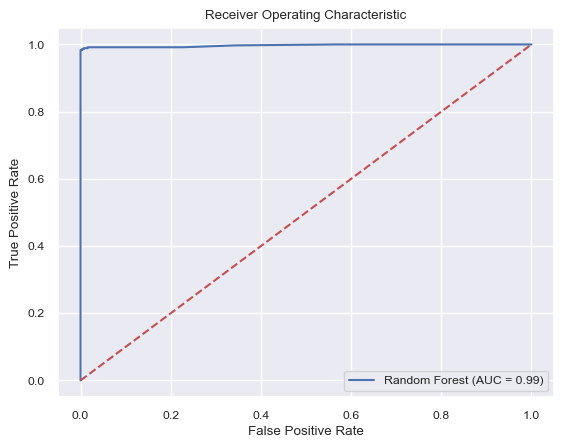

In [67]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
roc_auc = roc_auc_score(best_pipe["y_test"], best_pipe["y_pred"])
fpr, tpr, thresholds = roc_curve(best_pipe["y_test"], best_pipe["y_pred_proba"])

plt.figure()
plt.plot(fpr, tpr, label="{} (AUC = {:.2f})".format(best_pipe["model_name"], roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Feature importance

Because the best model is Random Forest, which is a tree-based algorithm, we can use the built-in feature_importance_ method to see how significant the features are at predicting the target variable. 

In [68]:
# Features used
features_idx = best_pipe["pipe"]["selector"].get_support()
features_used = features.columns[features_idx]

Text(0.5, 0, 'Feature Importance')

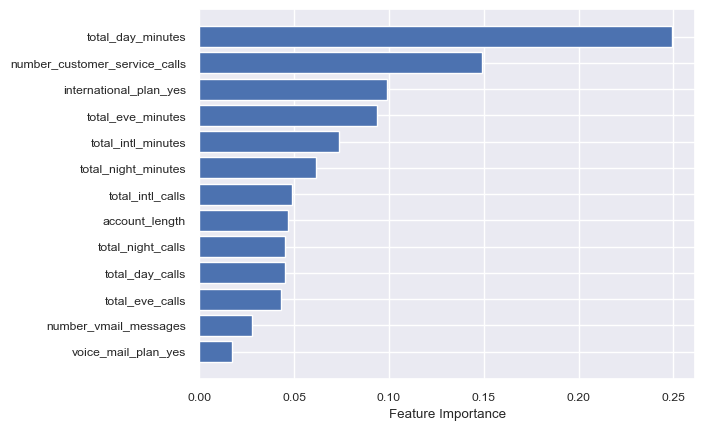

In [69]:
sorted_idx = best_pipe["pipe"]["classifier"].feature_importances_.argsort()
plt.barh(features_used[sorted_idx], best_pipe["pipe"]["classifier"].feature_importances_[sorted_idx])
plt.xlabel("Feature Importance")

Based on the feature importance plot above, we may conclude that <b>total_day_minutes</b> is the most important feature, which matches with the second hypothesis. 

Also, the <b>international_plan</b> feature also plays an important role in detecting churn loyal customers, as stated in the first hypothesis. 

### Confusion matrix

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

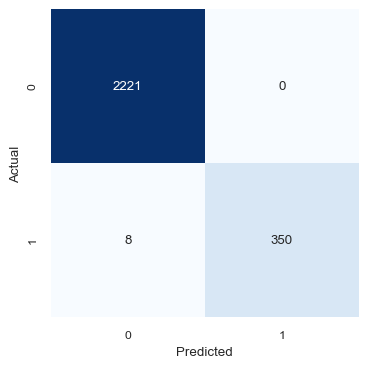

In [70]:
cm = confusion_matrix(best_pipe["y_test"], best_pipe["y_pred"])
df_cm = pd.DataFrame(cm, columns=np.unique(best_pipe["y_test"]), index = np.unique(best_pipe["y_test"]))
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
plt.figure(figsize=(4,4))
sns.heatmap(df_cm, cbar=False, square=True, cmap="Blues", annot=True, fmt=".0f")

### Classification report

In [71]:
print(classification_report(best_pipe["y_test"], best_pipe["y_pred"], zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2221
           1       1.00      0.98      0.99       358

    accuracy                           1.00      2579
   macro avg       1.00      0.99      0.99      2579
weighted avg       1.00      1.00      1.00      2579



Obviously, there are 358 samples that are actually churn customers, and only 8 were not detected. 

Therefore, Precision = TP/(TP+FP) = 350/350 = 1; and Recall = TP/(TP+FN) = 350/(350+8) = 0.978 as given in the classification report. 

## 8. Out-of-sample prediction

### Create a synthetic dataset 

The synthetic data is taken from the summary statistics table

In [72]:
sample_1 = pd.DataFrame(df.describe().loc["min", :].append(pd.Series([0, 1], index=['international_plan_yes', 'voice_mail_plan_yes']))).T
sample_2 = pd.DataFrame(df.describe().loc["25%", :].append(pd.Series([0, 1], index=['international_plan_yes', 'voice_mail_plan_yes']))).T

In [73]:
# Concat 2 dataframes
synthetic_df = pd.concat([sample_1, sample_2], axis=0, ignore_index=True)

In [74]:
# Check the structure of the synthetic dataframe
synthetic_df

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn,international_plan_yes,voice_mail_plan_yes
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,73.000000,0.000000,144.000000,87.000000,166.200000,87.000000,167.000000,87.000000,8.500000,3.000000,1.000000,0.000000,0.000000,1.000000


In [75]:
# Add missing features (compared to the original dummy dataframe used to train the model)
mising_dummies = [f for f in features.columns if f not in synthetic_df.columns]
for f in mising_dummies:
    synthetic_df[f] = 0
    
# Re-arrange the order
synthetic_df = synthetic_df[features.columns]
synthetic_df

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_415,area_code_510,international_plan_yes,voice_mail_plan_yes
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0.000000,1.000000
1,73.000000,0.000000,144.000000,87.000000,166.200000,87.000000,167.000000,87.000000,8.500000,3.000000,...,0,0,0,0,0,0,0,0,0.000000,1.000000


### Using the best model to make predictions

In [76]:
best_pipe["pipe"].predict(synthetic_df)

array([0, 0])

Both 2 synthetic samples have low values of <b>total_day_minutes</b> and do not have <b>international calling plan</b>, which are deciding factors in predicting churn customers. In fact, they are predicted to be loyal (non-churn), which goes well with the observations in the EDA section. 

## 9. Model deployment

### Deploy model in production

In order to make the model more production-ready, an API has been developed using (Python) Flask, a web development framework.

The source code of this part is saved in the <b>Deployment</b> folder. 

<img src="Deployment\demo.png" alt="Demo API" />